<a href="https://colab.research.google.com/github/reiinakano/neural-painters-pytorch/blob/master/notebooks/visualizing_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [1]:
# Check GPU being used. We suggest resetting the environment until you get a P100, otherwise optimization will be slow
!nvidia-smi

Fri Dec  6 08:01:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#!rm -r neural-painters-pytorch
#!rm -r neural_painters
!git clone https://github.com/reiinakano/neural-painters-pytorch.git
!cp -r neural-painters-pytorch/neural_painters neural_painters

Cloning into 'neural-painters-pytorch'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 261 (delta 168), reused 179 (delta 97), pack-reused 0
Receiving objects: 100% (261/261), 8.50 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [3]:
!pip install kornia

     |████████████████████████████████| 122kB 6.2MB/s 


In [4]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2019-12-06 08:02:40--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.134.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.134.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.08s   

2019-12-06 08:02:40 (420 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



# imports

In [5]:
import torch
import torchvision
import torchvision.utils as utils
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import json
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
import moviepy.editor as mpy

from neural_painters.vae_painter import VAENeuralPainter
from neural_painters.gan_painter import GANNeuralPainter
from neural_painters.data import FullActionStrokeDataLoader
from neural_painters.canvas import NeuralCanvas
from neural_painters.transforms import RandomRotate, Normalization
from neural_painters.viz import plot_images, animate_frames

import kornia

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3407872/45929032 bytes (7.4%)7249920/45929032 bytes (15.8%)11091968/45929032 bytes (24.2%)14852096/45929032 bytes (32.3%)18563072/45929032 bytes (40.4%)22282240/45929032 bytes (48.5%)26116096/45929032 bytes (56.9%)29933568/45929032 bytes (65.2%)33611776/45929032 bytes (73.2%)37298176/45929032 bytes (81.2%)40984576/45929032 bytes (89.2%)44662784/45929032 bytes (97.2%)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# all 0 to 1
ACTIONS_TO_IDX = {
    'pressure': 0,
    'size': 1,
    'control_x': 2,
    'control_y': 3,
    'end_x': 4,
    'end_y': 5,
    'color_r': 6,
    'color_g': 7,
    'color_b': 8,
    'start_x': 9,
    'start_y': 10,
    'entry_pressure': 11,
}

class_idx = json.load(open("imagenet_class_index.json"))
idx2label = {k: class_idx[str(k)][1] for k in range(len(class_idx))}
label2idx = {class_idx[str(k)][1]: k for k in range(len(class_idx))}

In [7]:
inception_v1 = torch.hub.load('pytorch/vision', 'googlenet', pretrained=True)
_ = inception_v1.eval().to(device)

squeezenet1_1 = torchvision.models.squeezenet1_1(pretrained=True)
_ = squeezenet1_1.eval().to(device)

vgg = torchvision.models.vgg19(pretrained=True)
_ = vgg.eval().to(device)

resnet = torchvision.models.resnet50(pretrained=True)
_ = resnet.eval().to(device)

mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
_ = mobilenet.eval().to(device)

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 39.8MB/s]
Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
100%|██████████| 4.74M/4.74M [00:00<00:00, 64.3MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.1MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.9MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.

# Utility code for searching available ImageNet classes

You don't really need this but I found it helpful to look for classes to optimize.

In [8]:
def search(_search_term):
  print('searching matching labels for {}'.format(_search_term))
  print([x for x in label2idx if _search_term in x])

search('e')

searching matching labels for e
['tench', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'hen', 'house_finch', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'American_chameleon', 'frilled_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'green_mamba', 'sea_snake', 'horned_viper', 'sidewinder', 'trilobite', 'harvestman', 'black_and_gold_garden_spider', 'barn_spider', 'garden_spider', 'wolf_spider', 'centipede', 'black_grouse', 'ruffed_grouse', 'prairie_chicken', 'peacock', 'partridge', 'African_grey', 'sulphur-crested_cockatoo', 

# Choosing parameters

In [12]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto", display-mode: "form" }

CATEGORY_TO_OPTIMIZE = "giant_panda" #@param {type:"string"}
#@markdown Some of my favorite categories are "bee", "giant_panda", "strawberry", "ice_bear", "pelican" 
search(CATEGORY_TO_OPTIMIZE)
CLASS_IDX = label2idx[CATEGORY_TO_OPTIMIZE]
NUM_STROKES = 30 #@param {type:"slider", min:1, max:100, step:1}
BATCH_SIZE = 5 #@param {type:"slider", min:1, max:5, step:1}
PAINTER_TYPE = "VAE" #@param ["GAN", "VAE"]
#@markdown VAE mode results in more solid strokes that are easier to optimize.
#@markdown GAN mode results in strokes that actually look like paintbrush strokes, although they might be harder to optimize.
STOCHASTIC = True #@param {type:"boolean"}
#@markdown Experimental. Adding uncertainty may (or may not) help produce more robust images.
LEARNING_RATE = 0.05 #@param {type: "number"}
TILE_SIZE = 3

#@markdown ---
#@markdown ### Choose which models are optimized *at the same time*:
USE_INCEPTION_V1 = True #@param {type:"boolean"}
USE_SQUEEZENET_1_1 = False #@param {type:"boolean"}
USE_VGG_19 = True #@param {type:"boolean"}
USE_MOBILENET_V2 = True #@param {type:"boolean"}
USE_RESNET_50 = True #@param {type:"boolean"}

MODELS_TO_OPTIMIZE = []
MODELS_TO_OPTIMIZE_STR = []
if USE_INCEPTION_V1:
  MODELS_TO_OPTIMIZE.append(inception_v1)
  MODELS_TO_OPTIMIZE_STR.append('inception v1')
if USE_SQUEEZENET_1_1:
  MODELS_TO_OPTIMIZE.append(squeezenet1_1)
  MODELS_TO_OPTIMIZE_STR.append('squeezenet 1_1')
if USE_VGG_19:
  MODELS_TO_OPTIMIZE.append(vgg)
  MODELS_TO_OPTIMIZE_STR.append('vgg 19')
if USE_MOBILENET_V2:
  MODELS_TO_OPTIMIZE.append(mobilenet)
  MODELS_TO_OPTIMIZE_STR.append('mobilenet v2')
if USE_RESNET_50:
  MODELS_TO_OPTIMIZE.append(resnet)
  MODELS_TO_OPTIMIZE_STR.append('resnet 50')

print("Category to optimize", CATEGORY_TO_OPTIMIZE, CLASS_IDX)
print("Number of strokes", NUM_STROKES)
print("Batch size", BATCH_SIZE)
print("Using {} painter".format(PAINTER_TYPE))
print("Stochastic", STOCHASTIC)
print("Learning Rate", LEARNING_RATE)
print("Models to optimize", MODELS_TO_OPTIMIZE_STR)
print('--------------------')


searching matching labels for giant_panda
['giant_panda']
Category to optimize giant_panda 388
Number of strokes 30
Batch size 5
Using VAE painter
Stochastic True
Learning Rate 0.05
Models to optimize ['inception v1', 'vgg 19', 'mobilenet v2', 'resnet 50']
--------------------


# Run optimization

Make sure to stop the optimization when you are happy with the results. Rarely do I need to go above 1500 steps.

Downloading...
From: https://drive.google.com/uc?id=1ETysXz9xFIooMlVvwlo5erENmU9JkKMv
To: /root/.cache/neural_painters/checkpoints/vae_neural_painter_latest.tar
53.8MB [00:00, 215MB/s]


Downloaded pretrained checkpoint to /root/.cache/neural_painters/checkpoints/vae_neural_painter_latest.tar
Loaded from /root/.cache/neural_painters/checkpoints/vae_neural_painter_latest.tar. Batch 450000
Step 0	Cost 4.071126937866211	Costs [0.19316928 0.2927596  0.27011824 0.28774658 0.20319301 0.30471206
 0.3382973  0.2521356  0.3959822  0.22644007 0.18551385 0.3693431
 0.2064459  0.3155203  0.2297498 ]


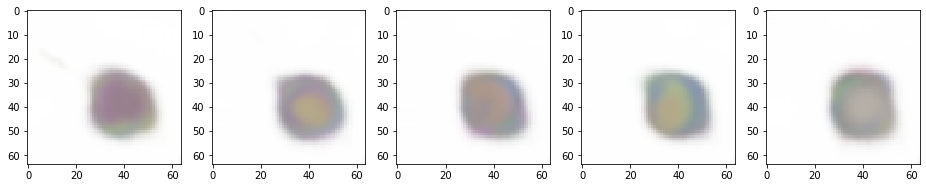

Step 100	Cost -58.97117614746094	Costs [-3.9147053 -4.1951957 -4.0174656 -4.1152515 -3.6449573 -3.8964024
 -4.0460677 -3.6782813 -4.2999325 -2.8302364 -3.8768082 -4.2014904
 -3.919549  -4.272479  -4.0623507]


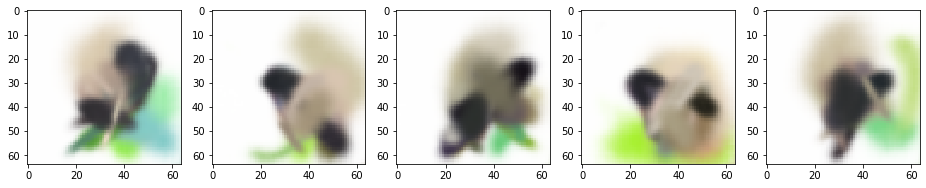

Step 200	Cost -76.39531707763672	Costs [-5.6219654 -4.6440663 -5.9040217 -5.5652275 -5.040067  -4.744704
 -5.1537333 -5.102069  -5.567329  -5.5623665 -4.700226  -3.8727322
 -5.632219  -4.999937  -4.2846518]


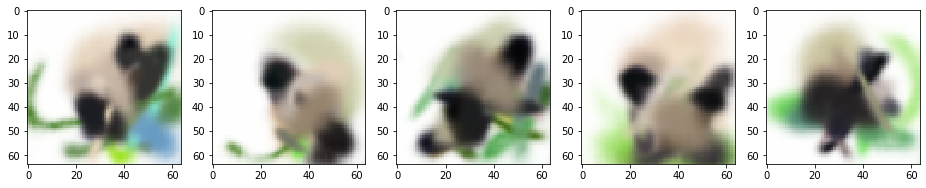

Step 300	Cost -91.26386260986328	Costs [-6.222294  -5.478524  -7.5801353 -6.022542  -4.6878147 -6.2575283
 -4.1284432 -7.552682  -6.5317836 -6.349616  -6.039207  -4.920191
 -7.37167   -5.702054  -6.4193764]


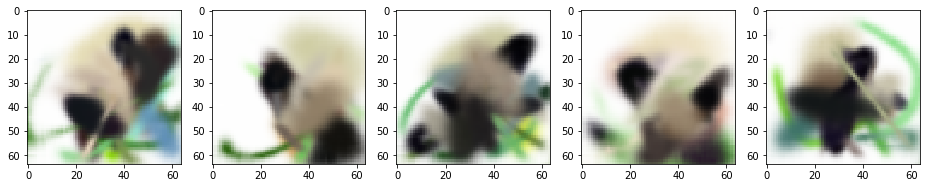

Step 400	Cost -94.13416290283203	Costs [-7.2634478 -5.528467  -7.5747414 -6.5897703 -6.957261  -6.632675
 -3.4996324 -8.044922  -6.0591025 -6.734308  -7.39194   -5.1663237
 -5.240242  -6.5695014 -4.881828 ]


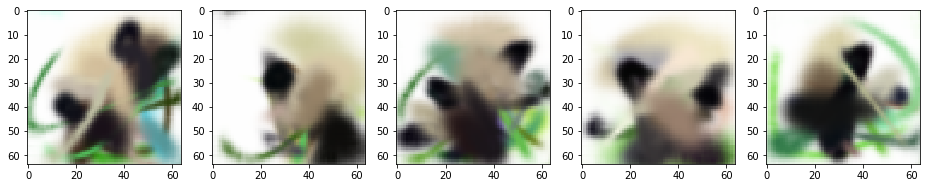

Step 500	Cost -103.19068908691406	Costs [-5.9922996 -6.1592765 -7.6991076 -5.5902624 -7.414912  -8.079271
 -5.880146  -8.182976  -6.296277  -7.3268485 -7.9179015 -5.1919017
 -6.92939   -6.5003753 -8.029742 ]


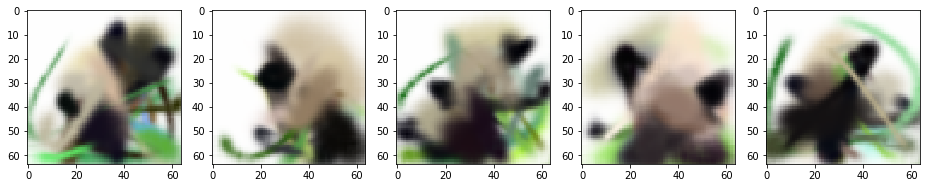

Step 600	Cost -112.46417236328125	Costs [-7.5888567 -4.3133965 -8.34678   -7.043664  -6.7820177 -7.967859
 -6.8414516 -8.166304  -7.1568565 -8.447246  -7.98715   -7.320636
 -8.63938   -7.354538  -8.508041 ]


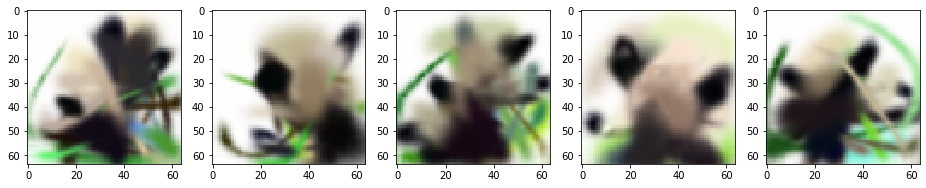

Step 700	Cost -119.26722717285156	Costs [-7.9055476 -7.7151527 -8.444053  -8.278061  -8.260485  -8.038652
 -7.3940783 -8.996666  -7.748661  -7.601012  -7.91833   -5.9304385
 -9.222885  -7.8335967 -7.9796047]


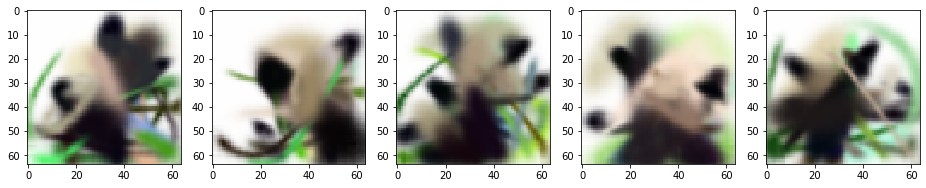

KeyboardInterrupt: ignored

In [13]:
if PAINTER_TYPE == 'VAE':
  neural_painter = VAENeuralPainter(action_size=len(ACTIONS_TO_IDX), z_size=64, stochastic=STOCHASTIC, 
                                    pretrained=True).to(device).eval()
elif PAINTER_TYPE == 'GAN':
  neural_painter = GANNeuralPainter(action_size=len(ACTIONS_TO_IDX), noise_dim=16, 
                                    num_deterministic=0 if STOCHASTIC else 16, pretrained=True).to(device).eval()
else:
  raise NotImplementedError

canvas = NeuralCanvas(neural_painter=neural_painter)

actions = torch.FloatTensor(NUM_STROKES, BATCH_SIZE, len(ACTIONS_TO_IDX)).uniform_().to(device)

optimizer = optim.Adam([actions.requires_grad_()], lr=LEARNING_RATE)

normalizer = Normalization(torch.tensor([0.485, 0.456, 0.406]).to(device), 
                           torch.tensor([0.229, 0.224, 0.225]).to(device))
#normalizer = Normalization(torch.tensor([0.5, 0.5, 0.5]).to(device), 
#                           torch.tensor([0.5, 0.5, 0.5]).to(device))
random_rotater = RandomRotate(angle=20)

canvases = []
for idx in range(1500):
  optimizer.zero_grad()

  # Generate final canvas with all strokes
  output_canvas, _ = canvas(actions)
  canvases.append(output_canvas.detach().cpu())

  # Image transformations
  tiled_canvas = output_canvas.repeat(TILE_SIZE, 1, 1, 1)
  augmented_canvas = random_rotater(normalizer(tiled_canvas))
  augmented_canvas = F.interpolate(augmented_canvas, size=[224, 224], mode='bilinear')

  # Pass through pretrained
  out_classes = 0
  for clf in MODELS_TO_OPTIMIZE:
    out_classes += clf(augmented_canvas)
  out_classes = out_classes / (float(len(MODELS_TO_OPTIMIZE)) * float(TILE_SIZE))

  costs = -out_classes[:, CLASS_IDX]
  cost = costs.sum()
  cost.backward()
  optimizer.step()
  if idx % 100 == 0:
    print(f'Step {idx}\tCost {cost.item()}\tCosts {costs.detach().cpu().numpy()}')
    plot_images((output_canvas.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1))
    plt.show()
    print('Make sure to stop the optimization when you are happy with the results')


# Visualize and watch the canvas "bloom"

In [14]:
def animate_canvases(canvases: List[torch.Tensor], skip_every_n: int = 1):
  canvases = canvases[::skip_every_n]
  canvases = [(x.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1)
              for x in canvases]
  canvases = [np.concatenate(x, axis=1) for x in canvases]
  animate_frames(canvases, 'tmp.mp4')

animate_canvases(canvases, skip_every_n=3)
display(mpy.ipython_display('tmp.mp4', height=150, max_duration=100.))

[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


100%|█████████▉| 240/241 [00:00<00:00, 293.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 

